<h1>Shared compounds</h1>

In [5]:
import os
import re
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns; sns.set()
import json
import numpy as np
import itertools

# Define charts settings
plt.rc('xtick',labelsize=14)
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["legend.framealpha"] = 1

# Select whether the experiment should be replicated or whether to fix bugs
fix_bugs = True

<h3>Load data</h3>

In [6]:
# Load list of compounds
with open(os.path.join('src', 'unique_compounds.txt'),"r") as input_dict:
    list_of_words=[]
    for line in input_dict:
        # ORIGINAL
        if not fix_bugs:
            # BUG: There are remaining \t signs in some words, e.g. 'þunwange\t'
            list_of_words+=line.strip("\n.").split(" ")
        # BUG FIXED
        else:
            wrds = line.strip("\n.").split(" ")
            list_of_words += [w.strip() for w in wrds]

In [7]:
# Load all words in corpus
with open(os.path.join('src', 'calgary_proce_x.txt'),"r") as input_file:
    words=[]
    for line in input_file:
        words+=line.strip("\n.").split(" ")

In [13]:
# Locate compounds in particular texts
title = ''
lineno = 1
linenobeo = 1
endline = '#'
locations = defaultdict(lambda: defaultdict(list))
line_counts = defaultdict(int)

for word in words:
    if '{' in word or '}' in word:
        if lineno > 1:
            line_counts[title] = lineno
        title = re.sub('[\{\}]', '', word)
        title = re.sub('christ3iii', 'christiii', title)
        lineno = 1
    if '#' in word:
        lineno += 1
        if title.startswith('beowulf'):
            linenobeo += 1
    if len(word) <= 3:
        continue
    
    for dword in list_of_words:
        is_compound = False
        if dword in word:
            locations[title][dword].append(lineno)
            if title.startswith('beowulf'):
                locations['beowulf'][dword].append(linenobeo)


<div style="border-top: 10px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>

<h3>Replicate Figure</h3>
<p>
We try to replicate Figure 3 using the theoretical model produced by matlab code (OECompClustNHB.m) and frequency tables provided by authors (OEdat_by_comp.mat). We do not merge Beowulf1 and Beowulf2, so the only comparable value to the article for these text is the value Beowulf1 to Beowulf2.
<ul><li>The result is pretty far from that given in Figure 3, especially it seems that ratio for Beowulf1-Beowulf2 is a way lower than in the article (cf. here, where precise ratios are given by the authors).</li></ul>


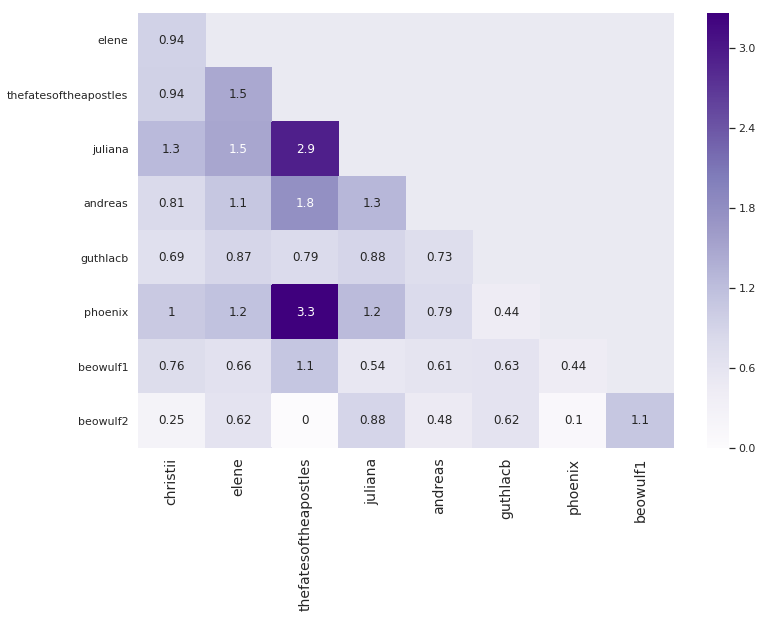

In [9]:
shared_compounds = defaultdict(dict)
selected_texts = ['christii', 'elene', 'thefatesoftheapostles', 'juliana', 
                  'andreas', 'guthlacb', 'phoenix','beowulf1', 'beowulf2',]

# Get compounds shared in pairs of selected texts and store it in pandas dataframe
for t1 in selected_texts:
    for t2 in selected_texts:
        if t1 == t2:
            continue
        cmp1 = set(locations[t1].keys())
        cmp2 = set(locations[t2].keys())
        cmp1.difference_update({'wuldorcyning', 'heofoncyning', 'heofonrice', 'middangeard'})
        shared_compounds[t1][t2] = len(cmp1.intersection(cmp2))
                
df_real = pd.DataFrame.from_dict(shared_compounds).fillna(0)

# Load text names
with open('src/compounds_prior_names.json') as f:  
    header = json.load(f)

# Unify names with the ones in dataframes            
for i,x in enumerate(header['names']):
    header['names'][i] = re.sub('thephoenix', 'phoenix', header['names'][i])
    header['names'][i] = header['names'][i].lower()
            
# Load data
df_prior = pd.read_csv('src/compounds_prior.csv', header=None, index_col=False)
df_prior.index = header['names']
df_prior.columns = header['names']
   
# Divide real frequencies by theoretical model
df_scores =  df_real / df_prior

# Sort dataframe as in original figure
df_scores = df_scores.reindex(index=selected_texts, columns=selected_texts)

# Extract lower triangular matrix
mask = np.tril(np.ones_like(df_scores, dtype=np.bool), k=-1)
df_scores = df_scores.where(mask)

# Plot the heatmap
ax = sns.heatmap(df_scores.iloc[1:, :-1], annot=True, cmap='Purples')

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
To check whether perhaps frequency tables are somehow corrupted, we have recalculated them from the textual data and generated random model again. (python code to extract frequencies and matlab code to generate the model are stored in the [compounds_model] folder)
<ul><li>The result seems more or less similar to the one above. The differences may be caused by the fact, that the texts employed in the original tables slightly differ from those in the corpus.</li></ul>

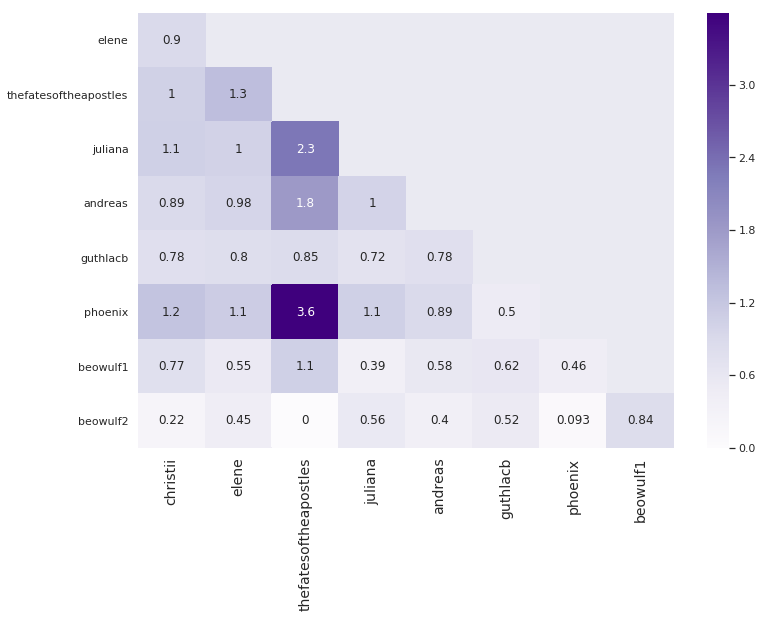

In [10]:
# Load text names
with open('compounds_model/compounds_prior_names.json') as f:  
    header2 = json.load(f)
            
# Load data
df_prior2 = pd.read_csv('compounds_model/compounds_prior.csv', header=None, index_col=False)
df_prior2.index = header2['names']
df_prior2.columns = header2['names']
   
# Divide real frequencies by theoretical model
df_scores =  df_real / df_prior2

# Sort dataframe as in original figure
df_scores = df_scores.reindex(index=selected_texts, columns=selected_texts)

# Extract lower triangular matrix
mask = np.tril(np.ones_like(df_scores, dtype=np.bool), k=-1)
df_scores = df_scores.where(mask)

# Plot the heatmap
ax = sns.heatmap(df_scores.iloc[1:, :-1], annot=True, cmap='Purples')

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Let's take a look at the values both models predict (lower triangular (purple) =original model, upper triangular (green) = new model)
<ul><li>It's pretty symmetrical</li></ul>

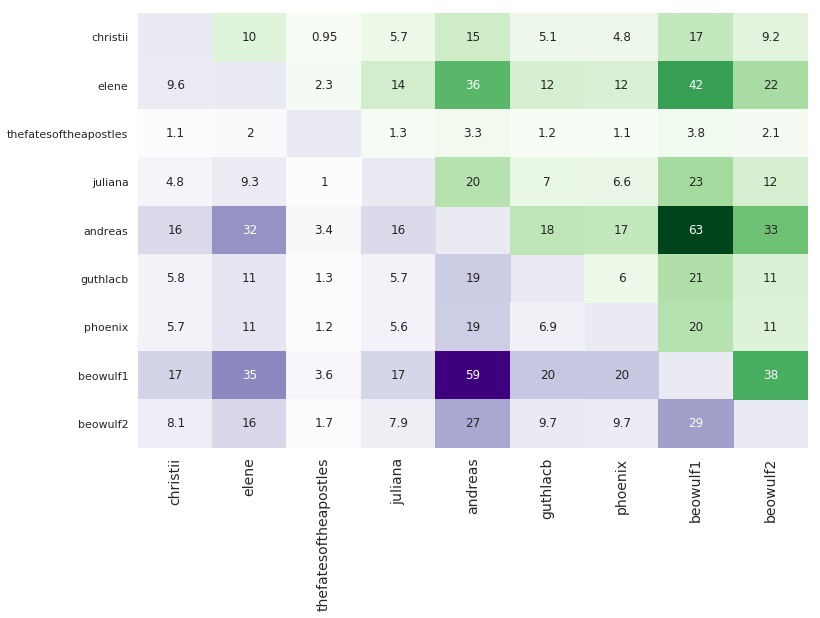

In [11]:
# Sort dataframes as in original figure
df_prior_ = df_prior.reindex(index=selected_texts, columns=selected_texts)
df_prior2_ = df_prior2.reindex(index=selected_texts, columns=selected_texts)

# Extract lower triangular matrix for original model (Purple) and upper triangular matrix for new model (Green)
mask = np.tril(np.ones_like(df_prior_, dtype=np.bool), k=-1)
df_prior_ = df_prior_.where(mask)
mask = np.triu(np.ones_like(df_prior2_, dtype=np.bool), k=1)
df_prior2_ = df_prior2_.where(mask)

# Plot the heatmap
ax = sns.heatmap(df_prior_, annot=True, cmap='Purples', cbar=False)
ax = sns.heatmap(df_prior2_, annot=True, cmap='Greens', cbar=False)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Let's take a look on how our results differ from the ones reported in the article. The table below shows the differences (except for Beowulf, where authors do not provide precise numbers).

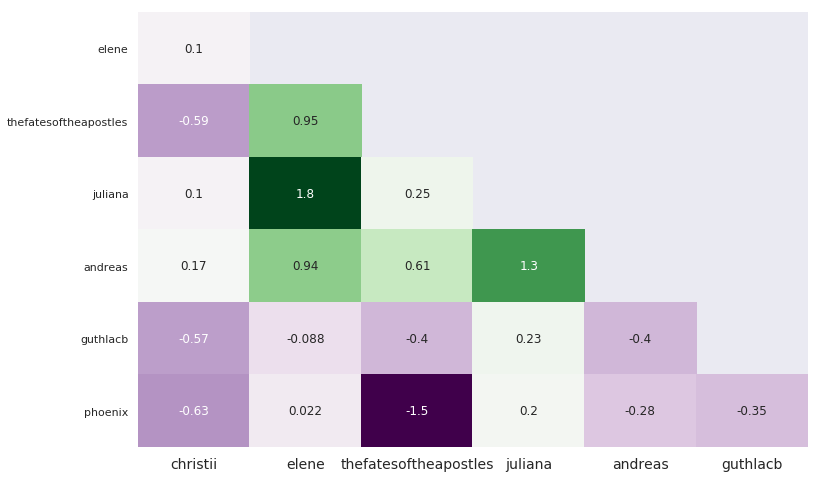

In [12]:
data_reported = [
    [1],
    [0.457142857, 2.275],
    [1.164285714, 2.871428571, 2.564285714],
    [1.067857143, 1.914285714, 2.432142857, 2.314285714],
    [0.210714286, 0.714285714, 0.45, 0.95, 0.378571429],
    [0.603571429, 1.132142857, 2.046428571, 1.260714286, 0.603571429, 0.155714286],
]

df_scores_original = pd.DataFrame(data_reported, index=list(selected_texts[1:7]), columns=selected_texts[0:6])
diff = df_scores_original - df_scores.iloc[1:-2,0:-3 ]
ax = sns.heatmap(diff, annot=True, cmap='PRGn', cbar=False)

<div style="border-top: 10px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>

<h3>Topic vs. Compounds</h3>
<p>
The data above doesn't say much about how does the topic related poems written by multiple authors behave in terms of these ratios (possible case of Beowulf). Let's try to incorporate Christ I and Christ III (Christ II already plotted).
<ul><li>The results show that the correlation between Christ I-III poems (written by different authors) is stronger than between most of the Cynnewulf-signed poems. This suggests that this metric is (as one may expect) rather topic-related than author-related.

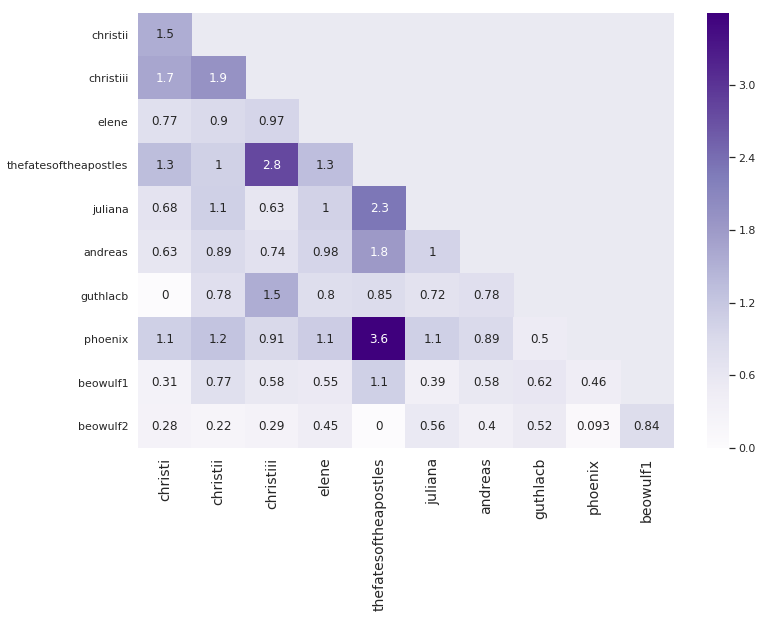

In [188]:
shared_compounds = defaultdict(dict)
selected_texts2 = ['christi', 'christii', 'christiii',
                  'elene', 'thefatesoftheapostles', 'juliana', 
                  'andreas', 'guthlacb', 'phoenix','beowulf1', 'beowulf2',]

# Get compounds shared in pairs of selected texts and store it in pandas dataframe
for t1 in selected_texts2:
    for t2 in selected_texts2:
        if t1 == t2:
            continue
        cmp1 = set(locations[t1].keys())
        cmp2 = set(locations[t2].keys())
        cmp1.difference_update({'wuldorcyning', 'heofoncyning', 'heofonrice', 'middangeard'})
        shared_compounds[t1][t2] = len(cmp1.intersection(cmp2))
                
df_real = pd.DataFrame.from_dict(shared_compounds).fillna(0)

# Load text names
with open('compounds_model/compounds_prior_names.json') as f:  
    header = json.load(f)

# Unify names with the ones in dataframes            
for i,x in enumerate(header['names']):
    header['names'][i] = re.sub('thephoenix', 'phoenix', header['names'][i])
    header['names'][i] = header['names'][i].lower()
            
# Load data
df_prior = pd.read_csv('compounds_model/compounds_prior.csv', header=None, index_col=False)
df_prior.index = header['names']
df_prior.columns = header['names']
   
# Divide real frequencies by theoretical model
df_scores =  df_real / df_prior

# Sort dataframe as in original figure
df_scores = df_scores.reindex(index=selected_texts2, columns=selected_texts2)

# Extract lower triangular matrix
mask = np.tril(np.ones_like(df_scores, dtype=np.bool), k=-1)
df_scores = df_scores.where(mask)

# Plot the heatmap
ax = sns.heatmap(df_scores.iloc[1:, :-1], annot=True, cmap='Purples')

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>

Finally to the question why Fates of the Apostles tends to have exceptionally high correlation with most of the other texts. 
<ul><li>
FotA is exceptional as each of the 13 compounds (+'middangeard') found in it is occuring only once (see its type-token compounds ratio compared to other poems below). The random model thus asigns a low probablity of shared compounds with other texts to it.
</ul></li>

dict_keys(['boldwela', 'wælreaf', 'ordfruma', 'lifwela', 'middangeard', 'lindgelaces', 'sigelean', 'eardwic', 'æfest', 'wundorcræfte', 'werþeod', 'beaducræft', 'apostolhad', 'foreþanc'])


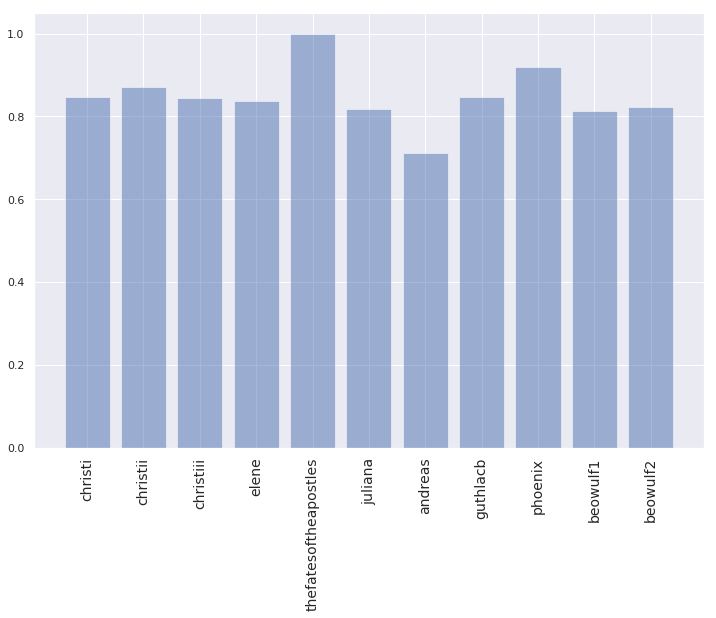

In [148]:
print(locations['thefatesoftheapostles'].keys())

selected_texts = ['christi', 'christii', 'christiii', 
                  'elene', 'thefatesoftheapostles', 'juliana', 
                  'andreas', 'guthlacb', 'phoenix','beowulf1', 'beowulf2',]
ttr = list()

for t in selected_texts:
    types = 0
    tokens = 0
    for w in locations[t]:
        if w in ('wuldorcyning', 'heofoncyning', 'heofonrice', 'middangeard'):
            continue
        tokens += len(locations[t][w])
        types += 1
    ttr.append(types/tokens)

y_pos = np.arange(len(selected_texts))
plt.bar(y_pos, ttr, align='center', alpha=0.5)
plt.xticks(y_pos, selected_texts, rotation='vertical')
plt.show()
    

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>

Now we just replicate the main chart in a way as published in the article - beowulf:beowulf displays data for beowulf1:beowulf2, with other poems the entire text of Beowulf is compared

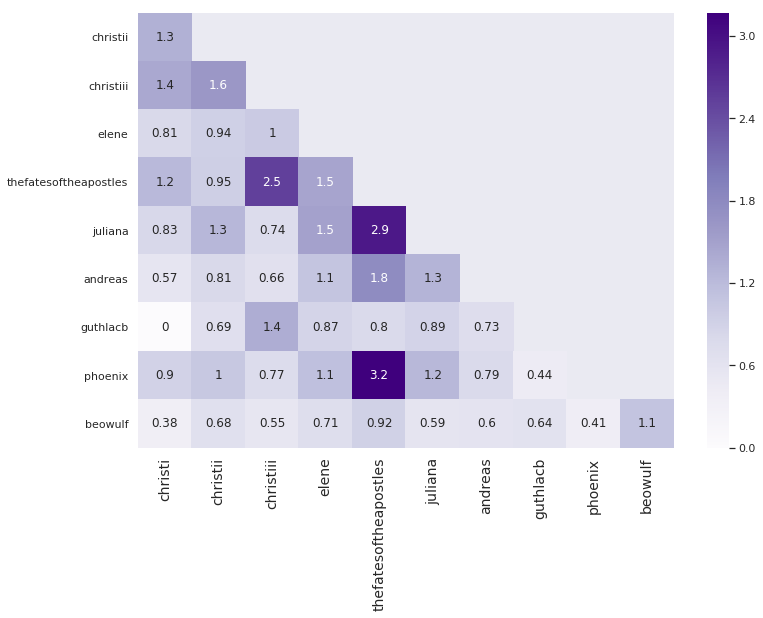

In [22]:
shared_compounds = defaultdict(dict)
selected_texts3 = ['christi', 'christii', 'christiii',
                  'elene', 'thefatesoftheapostles', 'juliana', 
                  'andreas', 'guthlacb', 'phoenix','beowulf']

# Get compounds shared in pairs of selected texts and store it in pandas dataframe
for t1 in selected_texts2:
    for t2 in selected_texts2:

        if t1 != 'beowulf' and t1 == t2:
            continue          

        if t1 == t2:
            t1_ = 'beowulf1'
            t2_ = 'beowulf2'
        else:
            t1_ = t1
            t2_ = t2

        cmp1 = set(locations[t1_].keys())
        cmp2 = set(locations[t2_].keys())
        cmp1.difference_update({'wuldorcyning', 'heofoncyning', 'heofonrice', 'middangeard'})
        shared_compounds[t1][t2] = len(cmp1.intersection(cmp2))
                
df_real = pd.DataFrame.from_dict(shared_compounds).fillna(0)

# Load text names
with open('src/compounds_prior_names.json') as f:  
    header = json.load(f)

# Unify names with the ones in dataframes            
for i,x in enumerate(header['names']):
    header['names'][i] = re.sub('thephoenix', 'phoenix', header['names'][i])
    header['names'][i] = header['names'][i].lower()
    # Rename beowulf1 (where model for entire poem is stored) to beowulf
    header['names'][i] = re.sub('beowulf1', 'beowulf', header['names'][i])
            
# Load data
df_prior = pd.read_csv('src/compounds_prior_beowulf.csv', header=None, index_col=False)
df_prior.index = header['names']
df_prior.columns = header['names']

# Rewrite beowulf:beowulf value with beowulf:beowulf2
df_prior.loc['beowulf', 'beowulf'] = df_prior.loc['beowulf', 'beowulf2']

# Divide real frequencies by theoretical model
df_scores =  df_real / df_prior

# Sort dataframe as in original figure
df_scores = df_scores.reindex(index=selected_texts2, columns=selected_texts3)

# Extract lower triangular matrix
mask = np.tril(np.ones_like(df_scores, dtype=np.bool), k=0)
df_scores = df_scores.where(mask)

# Plot the heatmap
ax = sns.heatmap(df_scores[1:], annot=True, cmap='Purples')

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>

Of course there's no proper research without hairball style network graph :)

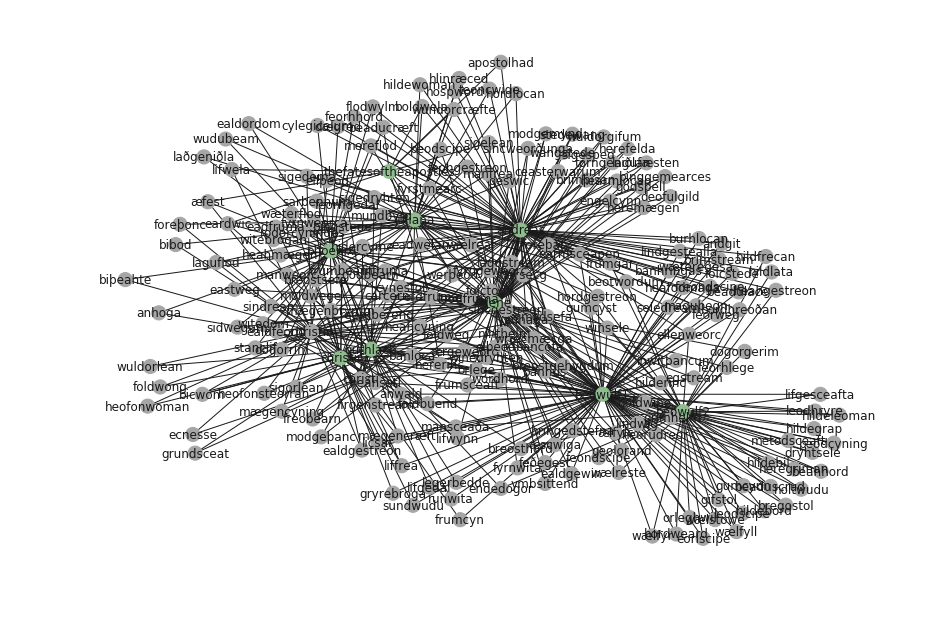

In [168]:
import networkx as nx
test = defaultdict(dict)

for t1 in selected_texts2:
    for t2 in selected_texts2:
        if t1 == t2:
            continue
        cmp1 = set(locations[t1].keys())
        cmp2 = set(locations[t2].keys())
        cmp1.difference_update({'wuldorcyning', 'heofoncyning', 'heofonrice', 'middangeard'})
        for w in cmp1.intersection(cmp2):
            test[t1][w] = 1
            test[t2][w] = 1
            test[w][t1] = 1
            test[w][t1] = 1

df_net = pd.DataFrame.from_dict(test).fillna(0)
graph = nx.from_numpy_matrix(df_net.values)
graph = nx.relabel_nodes(graph, dict(enumerate(df_net.columns)))
color_map = list()
for node in graph:
    if node in selected_texts:
        color_map.append('#8FBC8F')
    else:
        color_map.append('#a6a6a6')
nx.draw(graph, node_color = color_map, with_labels = True, node_size=200)
plt.show()